In [1]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
from drivers.graph_models import TreeNode, Order, Family, graph, pickNode
from drivers.tree_builder import TreeNeo
from traversals.strategies import sumTrees, UniformRandomSampleForest
import pandas as pd
import matplotlib.pyplot as plt
## Use the ggplot style
plt.style.use('ggplot')

## Let's start by picking a Family Node, e.g. The Bees in Mexico.

In [2]:
bees = pickNode(Family,name="Apidae")

In [3]:
# Extract the cells
bcells  = list(bees.cells)

In [4]:
len(bcells)

1118

### Get neighbours from the selected cells, reduce into a single list and then remove the duplicates (casting to set)

In [5]:
### In the form of a anonymous function
getNeighbours = lambda cells : list(set(reduce(lambda a,b : a+b , map(lambda cell : cell.getNeighbours(),cells))))

In [6]:
## Get neighbours in order 2
neighbour_cells = getNeighbours(getNeighbours(bcells))

## Here we create the response variable $y \sim Bin(p,k)$  

In [7]:
%time y = [1 if bee in bcells else 0 for bee in neighbour_cells]

CPU times: user 1min 23s, sys: 36 ms, total: 1min 23s
Wall time: 1min 23s


### We can extract the coordinates of neighbour cells and try to fit a model without covariates

In [8]:
%time coords = map(lambda c : (c.centroid.x,c.centroid.y) , neighbour_cells)

CPU times: user 2.16 s, sys: 4 ms, total: 2.17 s
Wall time: 2.17 s


In [9]:
lon,lat = zip(*coords)

In [10]:
X = pd.DataFrame([lon,lat])
Y = pd.DataFrame(y)

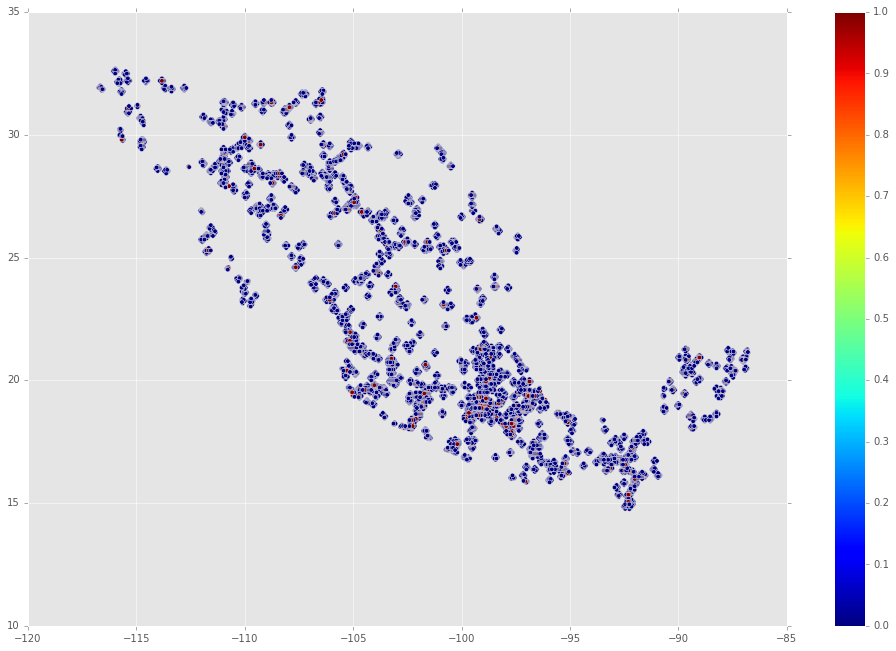

In [11]:
plt.figure(figsize=(17,11))
plt.scatter(lon,lat,c=Y)
plt.colorbar()

In [12]:
data = pd.concat([Y,X.transpose()],axis=1)
data.columns = ['Presences','lon','lat']

In [13]:
import redis as r

In [14]:
#cc = r.StrictRedis('10.42.72.93')
cc.keys()

NameError: name 'cc' is not defined

In [ ]:
## Import to redis
cc.set("bees1", data.to_csv())

In [15]:
# Import GPFlow
import GPflow as gf
k = gf.kernels.Matern12(2, lengthscales=1, active_dims = [0,1] )
model = gf.gpr.GPR(X.transpose().as_matrix(),Y.as_matrix().reshape(len(Y),1).astype(float),k)


len(X)
%time model.optimize()

In [16]:
model.kern.lengthscales = 320.49
model.kern.variance = 0.011

In [17]:
import numpy as np
Nn = 100
dsc = data
predicted_x = np.linspace(min(dsc.lon),max(dsc.lon),Nn)
predicted_y = np.linspace(min(dsc.lat),max(dsc.lat),Nn)
Xx, Yy = np.meshgrid(predicted_x,predicted_y)
## Fake richness
fake_sp_rich = np.ones(len(Xx.ravel()))
predicted_coordinates = np.vstack([ Xx.ravel(), Yy.ravel()]).transpose()
#predicted_coordinates = np.vstack([section.SppN, section.newLon,section.newLat]).transpose()

In [18]:
%time means,variances = model.predict_y(predicted_coordinates)

CPU times: user 2min 27s, sys: 2.75 s, total: 2min 30s
Wall time: 2min 22s


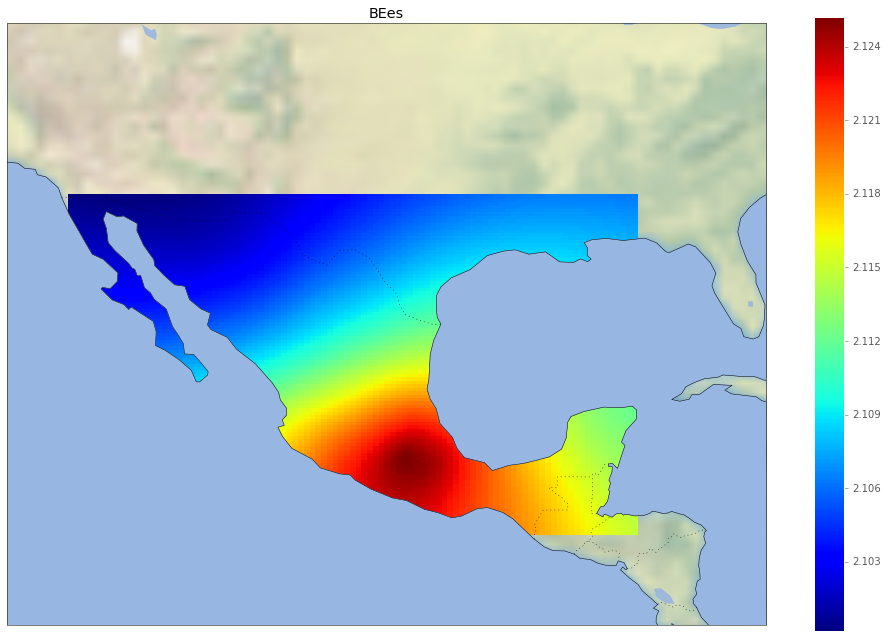

In [19]:
import cartopy
plt.figure(figsize=(17,11))

proj = cartopy.crs.PlateCarree()
ax = plt.subplot(111, projection=proj)


ax = plt.axes(projection=proj)
#algo = new_data.plot(column='SppN',ax=ax,cmap=colormap,edgecolors='')


#ax.set_extent([-93, -70, 30, 50])
ax.set_extent([-120, -80, 10, 40])
#ax.set_extent([-95, -70, 25, 45])

#ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.9)
ax.stock_img()
#ax.add_geometries(new_data.geometry,crs=cartopy.crs.PlateCarree())
#ax.add_feature(cartopy.feature.RIVERS)
mm = ax.pcolormesh(Xx,Yy,means.reshape(Nn,Nn) + (2* np.sqrt(variances).reshape(Nn,Nn)),transform=proj )
#cs = plt.contour(Xx,Yy,np.sqrt(variances).reshape(Nn,Nn),linewidths=2,cmap=plt.cm.Greys_r,linestyles='dotted')
cs = plt.contour(Xx,Yy,means.reshape(Nn,Nn) + (2 * np.sqrt(variances).reshape(Nn,Nn)),linewidths=2,colors='k',linestyles='dotted',levels=range(1,20))
plt.clabel(cs, fontsize=16,inline=True,fmt='%1.1f')
#ax.scatter(new_data.lon,new_data.lat,edgecolors='',color='white',alpha=0.6)
plt.colorbar(mm)
plt.title("BEes")

## This is a GP . 
We need to use here a GLM with Binomial family. 
The MCMC solver is not working. Need more time to test it.

In [ ]:
import tensorflow as tf
import GPflow as gf
import pandas as pd

In [ ]:

import pandas as pd
run traversals/tests.py
k = gf.kernels.Matern12(2, lengthscales=1, active_dims = [3,4])
X = pd.concat((rd[['MeanTemperature_mean','Precipitation_mean','WindSpeed_mean']],s[['Longitude','Latitude']]),axis=1)
Y = rd['Elevation_mean']
mx = X.as_matrix()
my = Y.as_matrix().reshape(16,1)
meanf = gf.mean_functions.Linear(np.ones((5,1)), np.ones(1))
m = gf.gpr.GPR(mx,my,k,mean_function=meanf)
m.optimize()
print(m)